In [33]:
import pickle
import re
import pandas as pd  
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
plt.rcParams['figure.figsize'] = [20, 7]

from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Flatten
from keras.layers.embeddings import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import optimizers
import tensorflow.keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import spacy
import spacy_spanish_lemmatizer

from scipy import sparse
from scipy import stats

from modAL.models import ActiveLearner
from modAL import uncertainty

import warnings
warnings.filterwarnings('ignore')

In [3]:
pic = open('spanish_tweets.pickle', 'rb')
data = pickle.load(pic)
pic.close()

In [4]:
data

,user,content,date,lang,sentiment
767817507897872385,71463624,— ¿Nivel de inglés? — Alto. — Traduzca juguete...,Mon Aug 22 20:15:33 +0000 2016,es,NEU
772486813948575745,572924309,Si soy de área 4 y con suerte pase mate IV y m...,Sun Sep 04 17:29:43 +0000 2016,es,N
771871884451295233,158142748,Sabían que su after fav Teatro G. fue construi...,Sat Sep 03 00:46:12 +0000 2016,es,P
771947976302456832,132254421,Y hoy por primera vez me salí con el permiso d...,Sat Sep 03 05:48:34 +0000 2016,es,P
774741645484896256,105530236,"¿Para qué hacen coraje con Ambriz?, al final n...",Sat Sep 10 22:49:36 +0000 2016,es,N
...,...,...,...,...,...
811436261059792896,2227486286,@AmorAKilates @Roocio_Mk si me pasa lo mismo!,Wed Dec 21 05:00:55 +0000 2016,es,NONE
809280785182322688,140260506,@clauchoarrionda pquno ladra y ls demas retwitean,Thu Dec 15 06:15:49 +0000 2016,es,NEU
810772298911350784,3291225459,A mi desayuno le hizo falta un alfajor podrida...,Mon Dec 19 09:02:34 +0000 2016,es,N
813200690894045184,2257050336,Viste cuando necesitas que alguien te escuche ...,Mon Dec 26 01:52:07 +0000 2016,es,N


In [5]:
data.mean()

user    inf
dtype: float64

In [6]:
cleaned = []
tknz = TweetTokenizer(strip_handles = True, reduce_len = True)
lemwn = WordNetLemmatizer()
nlp = spacy.load('es_dep_news_trf')

for tweet in data['content']:
    
    text = []
    # Tokenizes the tweet
    text = tknz.tokenize(tweet)
    
    # Eliminates punctuations, roman numbers, and lowcaps every letter.
    nptext = []
    for token in text:
        new_token = re.sub('[^\w\s]', '', token)
        new_token = re.sub('^(?=[MDCLXVI])M*(C[MD]|D?C*)(X[CL]|L?X*)(I[XV]|V?I*)$', '', new_token)
        new_token = new_token.lower()

        

        new_token = re.sub('(?:^|\W)ja(?:$|\W)', 'XD', new_token)
        new_token = re.sub('(?:^|\W)jaja(?:$|\W)', 'XD', new_token)
        new_token = re.sub('(?:^|\W)jajaja(?:$|\W)', 'XD', new_token)
        new_token = re.sub('(?:^|\W)jajajaja(?:$|\W)', 'XD', new_token)
        new_token = re.sub('(?:^|\W)jajajajaja(?:$|\W)', 'XD', new_token)
        new_token = re.sub('(?:^|\W)jajajajajajaja(?:$|\W)', 'XD', new_token)
        new_token = re.sub('(?:^|\W)jajajajajajajaja(?:$|\W)', 'XD', new_token)
        new_token = re.sub('(?:^|\W)jajajajajajajajaja(?:$|\W)', 'XD', new_token)
        new_token = re.sub('(?:^|\W)ji(?:$|\W)', 'XD', new_token)
        new_token = re.sub('(?:^|\W)jiji(?:$|\W)', 'XD', new_token)
        new_token = re.sub('(?:^|\W)jijiji(?:$|\W)', 'XD', new_token)
        new_token = re.sub('(?:^|\W)jijijiji(?:$|\W)', 'XD', new_token)
        new_token = re.sub('(?:^|\W)jijijijiji(?:$|\W)', 'XD', new_token)
        new_token = re.sub('(?:^|\W)jijijijijijiji(?:$|\W)', 'XD', new_token)
        new_token = re.sub('(?:^|\W)jijijijijijijiji(?:$|\W)', 'XD', new_token)
        new_token = re.sub('(?:^|\W)jijijijijijijijiji(?:$|\W)', 'XD', new_token)

        
        if not new_token == '':
            nptext.append(new_token)
    text = nptext
    
    # Eliminates arabic numbers
    text = [x for x in text if not x.isnumeric()]
    
    # Eliminates stop words
    stops = set(stopwords.words('spanish')) #are all lower case
    text = [token for token in text if token not in stops]
    
    # De-tokenize the list and puts everything into a string.
    string = ' '.join(text)

    # lemmatization
    text = []
    for i, token in enumerate(nlp(string)):
        text.append(token.lemma_)

    # De-tokenize the list and puts everything into a string.
    string = ' '.join(text)
    
    # Cleaned string appendization to the list of cleaned tweets
    cleaned.append(string)
    
print(cleaned[:20])

['nivel inglés alto traduzca juguete toy u él él oración toy triste awww vengache pa acá', 'si área suerte pasar mate mate poner profe qlero mega difícil pasar último año', 'saber after fav teatro g construido día hoy ir dar placer vean ahí metido', 'hoy primero vez salir permiso mujer detalle si saber q lado q llegar casa', 'hacer coraje ambriz final ir correr salir típico frase culpa jugador', 'mamá nunca dejar disfrutar juventud mamá felipe llegar borracho año ayñ mamá', 'poder dormir despertar madrugada volver recurrente padre así', 'arrimar gustar entrepierna amor guardar pepino pene tanto grande ay', 'lejos lejos lejos manejar acá padre diferente q mal q feria caballo pq si quedar XD', 'ver cuanto akatsuki salir gaara imbécil sasuke primero episiodio', 'vida eterno dilema mejor dormir mañana terminar ingue voa desvelar morir acabar vez', 'ir ir dash cortado color piel color langosta hora sueño día permitir', 'cómo ir ver sputnik tampoco ir ir aguascalientes rebel tocar little va 

In [7]:
data.insert(loc = 2, value = cleaned, column = 'cleanned_content')
data

,user,content,cleanned_content,date,lang,sentiment
767817507897872385,71463624,— ¿Nivel de inglés? — Alto. — Traduzca juguete...,nivel inglés alto traduzca juguete toy u él él...,Mon Aug 22 20:15:33 +0000 2016,es,NEU
772486813948575745,572924309,Si soy de área 4 y con suerte pase mate IV y m...,si área suerte pasar mate mate poner profe qle...,Sun Sep 04 17:29:43 +0000 2016,es,N
771871884451295233,158142748,Sabían que su after fav Teatro G. fue construi...,saber after fav teatro g construido día hoy ir...,Sat Sep 03 00:46:12 +0000 2016,es,P
771947976302456832,132254421,Y hoy por primera vez me salí con el permiso d...,hoy primero vez salir permiso mujer detalle si...,Sat Sep 03 05:48:34 +0000 2016,es,P
774741645484896256,105530236,"¿Para qué hacen coraje con Ambriz?, al final n...",hacer coraje ambriz final ir correr salir típi...,Sat Sep 10 22:49:36 +0000 2016,es,N
...,...,...,...,...,...,...
811436261059792896,2227486286,@AmorAKilates @Roocio_Mk si me pasa lo mismo!,si pasar mismo,Wed Dec 21 05:00:55 +0000 2016,es,NONE
809280785182322688,140260506,@clauchoarrionda pquno ladra y ls demas retwitean,pquno ladra ls demas retwitear,Thu Dec 15 06:15:49 +0000 2016,es,NEU
810772298911350784,3291225459,A mi desayuno le hizo falta un alfajor podrida...,desayuno hacer falta alfajor podrido galleta a...,Mon Dec 19 09:02:34 +0000 2016,es,N
813200690894045184,2257050336,Viste cuando necesitas que alguien te escuche ...,ver necesitar alguien escuchar alguien bueno,Mon Dec 26 01:52:07 +0000 2016,es,N


In [8]:
cdata = data[['cleanned_content', 'sentiment']]
cdata = cdata.loc[cdata['sentiment'] != 'NONE']
cdata = cdata.loc[cdata['sentiment'] != 'NEU']
cdata['sentiment'].replace({'N': 0, 'P': 1}, inplace=True)
cdata

,cleanned_content,sentiment
772486813948575745,si área suerte pasar mate mate poner profe qle...,0
771871884451295233,saber after fav teatro g construido día hoy ir...,1
771947976302456832,hoy primero vez salir permiso mujer detalle si...,1
774741645484896256,hacer coraje ambriz final ir correr salir típi...,0
773634625126043649,mamá nunca dejar disfrutar juventud mamá felip...,0
...,...,...
810851272660230144,xd mucho gracia buen onda implicado,1
810740258035924992,fútbol hermoso cdo juntar talento este,1
810446500920782848,felizdomingo paz dios llenar vida bello día be...,1
810772298911350784,desayuno hacer falta alfajor podrido galleta a...,0


In [9]:
cdata.mean()

sentiment    0.425084
dtype: float64

In [10]:
x = cdata.cleanned_content
y = cdata.sentiment

In [11]:
SEED = 2000
x_train, x_validation, y_train, y_validation = train_test_split(x, y, test_size=.2, random_state=SEED)
#x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

In [12]:
#print("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive, {3:.2f}% neutral".format(len(x_train), (len(x_train[y_train == -1]) / (len(x_train)*1.))*100, (len(x_train[y_train == 1]) / (len(x_train)*1.))*100, (len(x_train[y_train == 0]) / (len(x_train)*1.))*100))
#print("Validation set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive, {3:.2f}% neutral".format(len(x_validation), (len(x_validation[y_validation == -1]) / (len(x_validation)*1.))*100, (len(x_validation[y_validation == 1]) / (len(x_validation)*1.))*100, (len(x_validation[y_validation == 0]) / (len(x_validation)*1.))*100))
#print("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive, {3:.2f}% neutral".format(len(x_test), (len(x_test[y_test == -1]) / (len(x_test)*1.))*100, (len(x_test[y_test == 1]) / (len(x_test)*1.))*100, (len(x_test[y_test == 0]) / (len(x_test)*1.))*100))

In [13]:
tvec1 = TfidfVectorizer(max_features=2000,ngram_range=(1, 3))
tvec1.fit(x_train)

TfidfVectorizer(max_features=2000, ngram_range=(1, 3))

In [14]:
x_train_tfidf = tvec1.transform(x_train)

In [15]:
tvec2 = TfidfVectorizer(max_features=2000,ngram_range=(1, 3))
tvec2.fit(x_validation)

TfidfVectorizer(max_features=2000, ngram_range=(1, 3))

In [16]:
x_validation_tfidf = tvec1.transform(x_validation).toarray()

In [17]:
%%time
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(x_train_tfidf, y_train)

Wall time: 560 ms


LogisticRegression()

In [18]:
clf.score(x_validation_tfidf, y_validation)

0.7454268292682927

In [19]:
clf.score(x_train_tfidf, y_train)

0.8641739793971767

In [20]:
seed = 7
np.random.seed(seed)

# Original Model

In [21]:
def batch_generator(X_data, y_data, batch_size):
    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    index = np.arange(np.shape(y_data)[0])
    while 1:
        index_batch = index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X_data[index_batch,:].toarray()
        y_batch = y_data[y_data.index[index_batch]]
        counter += 1
        yield np.array(X_batch), np.array(y_batch)
        if (counter > number_of_batches):
            counter=0

In [22]:
%%time
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=2000))
model.add(Dropout(0.9))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.9))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

a =model.fit_generator(generator=batch_generator(x_train_tfidf, y_train, 32),
                    epochs=25, validation_data=(x_validation_tfidf, y_validation),
                    steps_per_epoch=x_train_tfidf.shape[0]/32)

Epoch 1/25
81/81 [==============================] - 2s 7ms/step - loss: 0.6939 - accuracy: 0.5349 - val_loss: 0.6885 - val_accuracy: 0.5457
Epoch 2/25
81/81 [==============================] - 0s 2ms/step - loss: 0.6865 - accuracy: 0.5654 - val_loss: 0.6873 - val_accuracy: 0.5457
Epoch 3/25
81/81 [==============================] - 0s 1ms/step - loss: 0.6805 - accuracy: 0.5792 - val_loss: 0.6854 - val_accuracy: 0.5457
Epoch 4/25
81/81 [==============================] - 0s 1ms/step - loss: 0.6816 - accuracy: 0.5887 - val_loss: 0.6837 - val_accuracy: 0.5457
Epoch 5/25
81/81 [==============================] - 0s 1ms/step - loss: 0.6768 - accuracy: 0.5845 - val_loss: 0.6815 - val_accuracy: 0.5457
Epoch 6/25
81/81 [==============================] - 0s 1ms/step - loss: 0.6746 - accuracy: 0.5910 - val_loss: 0.6787 - val_accuracy: 0.5457
Epoch 7/25
81/81 [==============================] - 0s 1ms/step - loss: 0.6689 - accuracy: 0.5933 - val_loss: 0.6730 - val_accuracy: 0.5457
Epoch 8/25
81/81 [==

In [23]:
#Accuracy score
original_score = max(a.history['val_accuracy'])
original_score

0.7606707215309143

In [26]:
#F1 score
original_f1_score = 0
y_pred = model.predict_classes(x_validation_tfidf)[:,0]
original_f1_score = f1_score(y_validation, y_pred) 
original_f1_score

0.707635009310987

# AL

In [27]:
# build function for the Keras' scikit-learn API
def create_keras_model():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=2000))
    model.add(Dropout(0.9))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.9))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    return model

In [28]:
# create the classifier
classifier = KerasClassifier(create_keras_model)

In [29]:
# assemble initial data
y_train = np.asarray(y_train)
n_initial = 100
initial_idx = np.random.choice(range(len(x_train)), size=n_initial, replace=False)
X_initial = np.asarray(x_train_tfidf.todense()[initial_idx])
Y_initial = np.asarray(y_train[initial_idx])
y_train = np.transpose(y_train) # Reshaping of 1d to 2d array

# generate the pool
# remove the initial data from the training dataset
X_pool = np.delete(x_train_tfidf.todense(), initial_idx, axis=0)
y_pool = np.delete(y_train, initial_idx, axis=0)

In [34]:
# initialize ActiveLearner
learner = ActiveLearner(
    estimator=classifier, query_strategy = uncertainty.uncertainty_sampling,
    X_training=X_initial, y_training=Y_initial, verbose = 0)

In [35]:
%%time
# the active learning loop

n_queries = 25
uncertainity_scores = []
uncertainity_f1_scores = []
for idx in range(n_queries):
    print('Query no. %d' % (idx + 1))
    query_idx, query_instance = learner.query(X_pool, n_instances=100)
    learner.teach(
        X=X_pool[query_idx], y=y_pool[query_idx], only_new = False, epochs = 25, verbose = 0)
    
    # Accuracy score
    uncertainity_scores.append(learner.score(x_validation_tfidf, y_validation))
    
    #F1 score
    y_pred = learner.predict(x_validation_tfidf)[:,0]
    uncertainity_f1_scores.append(f1_score(y_validation, y_pred)) 
    
    # remove queried instance from pool
    X_pool = np.asarray(np.delete(X_pool, query_idx, axis=0))   
    y_pool = np.asarray(np.delete(y_pool, query_idx, axis=0))

Query no. 1
21/21 [==============================] - 0s 600us/step - loss: 0.6861 - accuracy: 0.5457
Query no. 2
21/21 [==============================] - 0s 600us/step - loss: 0.6888 - accuracy: 0.6479
Query no. 3
21/21 [==============================] - 0s 650us/step - loss: 0.6955 - accuracy: 0.4543
Query no. 4
21/21 [==============================] - 0s 550us/step - loss: 0.6797 - accuracy: 0.5473
Query no. 5
21/21 [==============================] - 0s 600us/step - loss: 0.6757 - accuracy: 0.5869
Query no. 6
21/21 [==============================] - 0s 600us/step - loss: 0.6622 - accuracy: 0.7149
Query no. 7
21/21 [==============================] - 0s 600us/step - loss: 0.6358 - accuracy: 0.7165
Query no. 8
21/21 [==============================] - 0s 600us/step - loss: 0.6253 - accuracy: 0.7348
Query no. 9
21/21 [==============================] - 0s 550us/step - loss: 0.6181 - accuracy: 0.7271
Query no. 10
21/21 [==============================] - 0s 600us/step - loss: 0.6257 - accura

In [36]:
# generate the pool
# remove the initial data from the training dataset
X_pool = np.delete(x_train_tfidf.todense(), initial_idx, axis=0)
y_pool = np.delete(y_train, initial_idx, axis=0)

In [37]:
# initialize ActiveLearner
learner = ActiveLearner(
    estimator=classifier, query_strategy = uncertainty.margin_sampling,
    X_training=X_initial, y_training=Y_initial, verbose = 0)

In [38]:
# the active learning loop
n_queries = 25
margin_scores = []
margin_f1_scores = []
for idx in range(n_queries):
    print('Query no. %d' % (idx + 1))
    query_idx, query_instance = learner.query(X_pool, n_instances=100)
    learner.teach(
        X=X_pool[query_idx], y=y_pool[query_idx], only_new = False, epochs = 25, verbose = 0)
    
    # Accuracy score
    margin_scores.append(learner.score(x_validation_tfidf, y_validation))
    
    #F1 score
    y_pred = learner.predict(x_validation_tfidf)[:,0]
    margin_f1_scores.append(f1_score(y_validation, y_pred)) 
    
    # remove queried instance from pool
    X_pool = np.asarray(np.delete(X_pool, query_idx, axis=0))   
    y_pool = np.asarray(np.delete(y_pool, query_idx, axis=0))

Query no. 1
21/21 [==============================] - 0s 650us/step - loss: 0.6868 - accuracy: 0.5457
Query no. 2
21/21 [==============================] - 0s 600us/step - loss: 0.6869 - accuracy: 0.5518
Query no. 3
21/21 [==============================] - 0s 600us/step - loss: 0.6949 - accuracy: 0.4543
Query no. 4
21/21 [==============================] - 0s 650us/step - loss: 0.6777 - accuracy: 0.6006
Query no. 5
21/21 [==============================] - 0s 600us/step - loss: 0.6702 - accuracy: 0.6220
Query no. 6
21/21 [==============================] - 0s 649us/step - loss: 0.6578 - accuracy: 0.6738
Query no. 7
21/21 [==============================] - 0s 650us/step - loss: 0.6506 - accuracy: 0.6951
Query no. 8
21/21 [==============================] - 0s 600us/step - loss: 0.6498 - accuracy: 0.7134
Query no. 9
21/21 [==============================] - 0s 600us/step - loss: 0.6329 - accuracy: 0.7119
Query no. 10
21/21 [==============================] - 0s 650us/step - loss: 0.6399 - accura

In [39]:
# generate the pool
# remove the initial data from the training dataset
X_pool = np.delete(x_train_tfidf.todense(), initial_idx, axis=0)
y_pool = np.delete(y_train, initial_idx, axis=0)

In [40]:
# initialize ActiveLearner
learner = ActiveLearner(
    estimator=classifier, query_strategy = uncertainty.entropy_sampling,
    X_training=X_initial, y_training=Y_initial, verbose = 0)

In [41]:
# the active learning loop
n_queries = 25
entropy_scores = []
entropy_f1_scores = []
for idx in range(n_queries):
    print('Query no. %d' % (idx + 1))
    query_idx, query_instance = learner.query(X_pool, n_instances=100)
    learner.teach(
        X=X_pool[query_idx], y=y_pool[query_idx], only_new = False, epochs = 25, verbose = 0)
    
    # Accuracy score
    entropy_scores.append(learner.score(x_validation_tfidf, y_validation))
    
    #F1 score
    y_pred = learner.predict(x_validation_tfidf)[:,0]
    entropy_f1_scores.append(f1_score(y_validation, y_pred)) 
    
    # remove queried instance from pool
    X_pool = np.asarray(np.delete(X_pool, query_idx, axis=0))   
    y_pool = np.asarray(np.delete(y_pool, query_idx, axis=0))

Query no. 1
21/21 [==============================] - 0s 650us/step - loss: 0.6879 - accuracy: 0.5457
Query no. 2
21/21 [==============================] - 0s 700us/step - loss: 0.6875 - accuracy: 0.5457
Query no. 3
21/21 [==============================] - 0s 600us/step - loss: 0.6928 - accuracy: 0.4543
Query no. 4
21/21 [==============================] - 0s 650us/step - loss: 0.6780 - accuracy: 0.5610
Query no. 5
21/21 [==============================] - 0s 600us/step - loss: 0.6757 - accuracy: 0.5976
Query no. 6
21/21 [==============================] - 0s 600us/step - loss: 0.6544 - accuracy: 0.6936
Query no. 7
21/21 [==============================] - 0s 600us/step - loss: 0.6482 - accuracy: 0.6875
Query no. 8
21/21 [==============================] - 0s 600us/step - loss: 0.6345 - accuracy: 0.7332
Query no. 9
21/21 [==============================] - 0s 650us/step - loss: 0.6011 - accuracy: 0.7195
Query no. 10
21/21 [==============================] - 0s 650us/step - loss: 0.6073 - accura

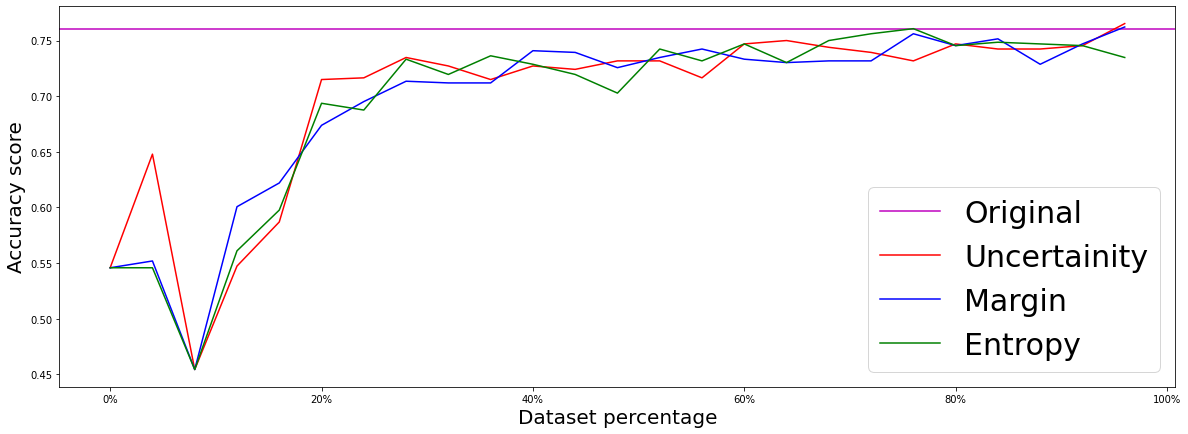

In [42]:
# Accuracy scores plot

plt.axhline(y=original_score, color='m', linestyle='-')
plt.ylabel('Accuracy score', fontsize = 20)
plt.xlabel('Dataset percentage', fontsize = 20)
fig = plt.figure(1, (7, 10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(uncertainity_scores, c = 'r')
ax.plot(margin_scores, c = 'b')
ax.plot(entropy_scores, c = 'g')
xticks = mtick.PercentFormatter(25)
ax.xaxis.set_major_formatter(xticks)
plt.legend(['Original', 'Uncertainity', 'Margin', 'Entropy'], fontsize = 30)
plt.show()

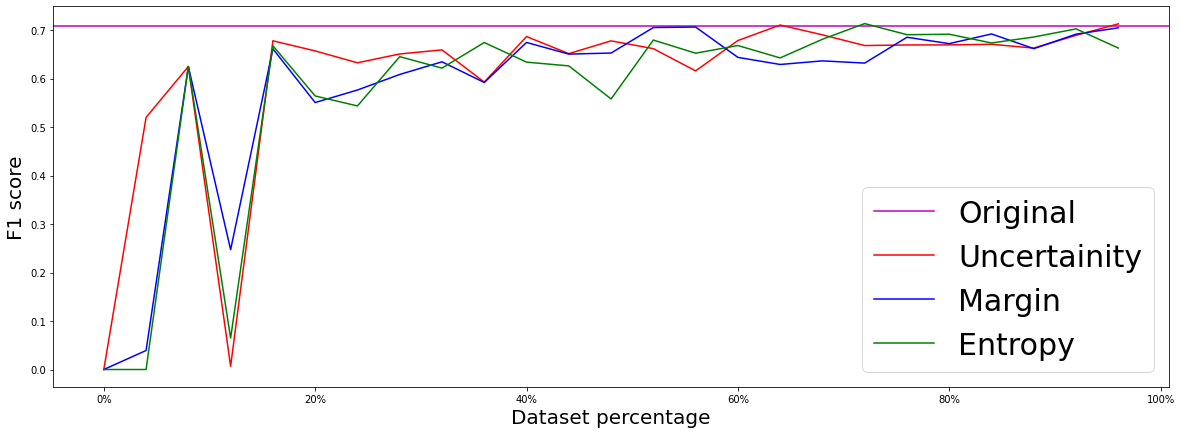

In [43]:
# Accuracy scores plot

plt.axhline(y=original_f1_score, color='m', linestyle='-')
plt.ylabel('F1 score', fontsize = 20)
plt.xlabel('Dataset percentage', fontsize = 20)
fig = plt.figure(1, (7, 10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(uncertainity_f1_scores, c = 'r')
ax.plot(margin_f1_scores, c = 'b')
ax.plot(entropy_f1_scores, c = 'g')
xticks = mtick.PercentFormatter(25)
ax.xaxis.set_major_formatter(xticks)
plt.legend(['Original', 'Uncertainity', 'Margin', 'Entropy'], fontsize = 30)
plt.show()